<a href="https://colab.research.google.com/github/mxn170019/Pneumonia-detection-using-X-ray-images/blob/master/Kaggle-Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Required Libraries


In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from pathlib import Path
import seaborn as sns
from skimage.io import imread

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score

import time


np.random.seed(111)


# Data Directory

In [0]:
# Define path to the data directory
data_dir = Path('/content/drive/My Drive/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

# Reading Train test and Val data files

## Training set

In [0]:
# Get the path to the normal and pneumonia sub-directories
train_normal_dir = train_dir / 'NORMAL'
train_pneumonia_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
train_normal_imgs = train_normal_dir.glob('*.jpeg')
train_pneumonia_imgs = train_pneumonia_dir.glob('*.jpeg')

#Generating the train data
train_data = []

#adding normal images to train data
for img in train_normal_imgs:
  train_data.append((img,0))

#adding pneumonia images to train data
for img in train_pneumonia_imgs:
  train_data.append((img,1))

#convering train list to data frame and visualize
train_df = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_df = train_df.sample(frac=1.).reset_index(drop=True)


display(train_df.head(5))
print(train_df.shape)
print(" ")
train_df['label'].value_counts()

,image,label
0,/content/drive/My Drive/chest_xray/train/PNEUM...,1
1,/content/drive/My Drive/chest_xray/train/PNEUM...,1
2,/content/drive/My Drive/chest_xray/train/PNEUM...,1
3,/content/drive/My Drive/chest_xray/train/PNEUM...,1
4,/content/drive/My Drive/chest_xray/train/PNEUM...,1


(5208, 2)
 


1    3867
0    1341
Name: label, dtype: int64

## Testing Set

In [0]:
# Get the path to the normal and pneumonia sub-directories
test_normal_dir = test_dir / 'NORMAL'
test_pneumonia_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_imgs = test_normal_dir.glob('*.jpeg')
test_pneumonia_imgs = test_pneumonia_dir.glob('*.jpeg')

#Generating the train data
test_data = []

#adding normal images to train data
for img in test_normal_imgs:
  test_data.append((img,0))

#adding pneumonia images to train data
for img in test_pneumonia_imgs:
  test_data.append((img,1))

#convering train list to data frame and visualize
test_df = pd.DataFrame(test_data, columns=['image', 'label'],index=None)
test_df = test_df.sample(frac=1.).reset_index(drop=True)


display(test_df.head(5))
print(test_df.shape)
print(" ")
test_df['label'].value_counts()

,image,label
0,/content/drive/My Drive/chest_xray/test/NORMAL...,0
1,/content/drive/My Drive/chest_xray/test/NORMAL...,0
2,/content/drive/My Drive/chest_xray/test/PNEUMO...,1
3,/content/drive/My Drive/chest_xray/test/PNEUMO...,1
4,/content/drive/My Drive/chest_xray/test/PNEUMO...,1


(624, 2)
 


1    390
0    234
Name: label, dtype: int64

## Validation Set

In [0]:
# Get the path to the normal and pneumonia sub-directories
val_normal_dir = val_dir / 'NORMAL'
val_pneumonia_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
val_normal_imgs = val_normal_dir.glob('*.jpeg')
val_pneumonia_imgs = val_normal_dir.glob('*.jpeg')

#Generating the train data
val_data = []

#adding normal images to train data
for img in val_normal_imgs:
  val_data.append((img,0))

#adding pneumonia images to train data
for img in val_pneumonia_imgs:
  val_data.append((img,1))

#convering train list to data frame and visualize
val_df = pd.DataFrame(val_data, columns=['image', 'label'],index=None)
val_df = val_df.sample(frac=1.).reset_index(drop=True)


display(val_df.head(5))
print(val_df.shape)
print(" ")
val_df['label'].value_counts()

,image,label
0,/content/drive/My Drive/chest_xray/val/NORMAL/...,0
1,/content/drive/My Drive/chest_xray/val/NORMAL/...,0
2,/content/drive/My Drive/chest_xray/val/NORMAL/...,0
3,/content/drive/My Drive/chest_xray/val/NORMAL/...,1
4,/content/drive/My Drive/chest_xray/val/NORMAL/...,1


(16, 2)
 


1    8
0    8
Name: label, dtype: int64

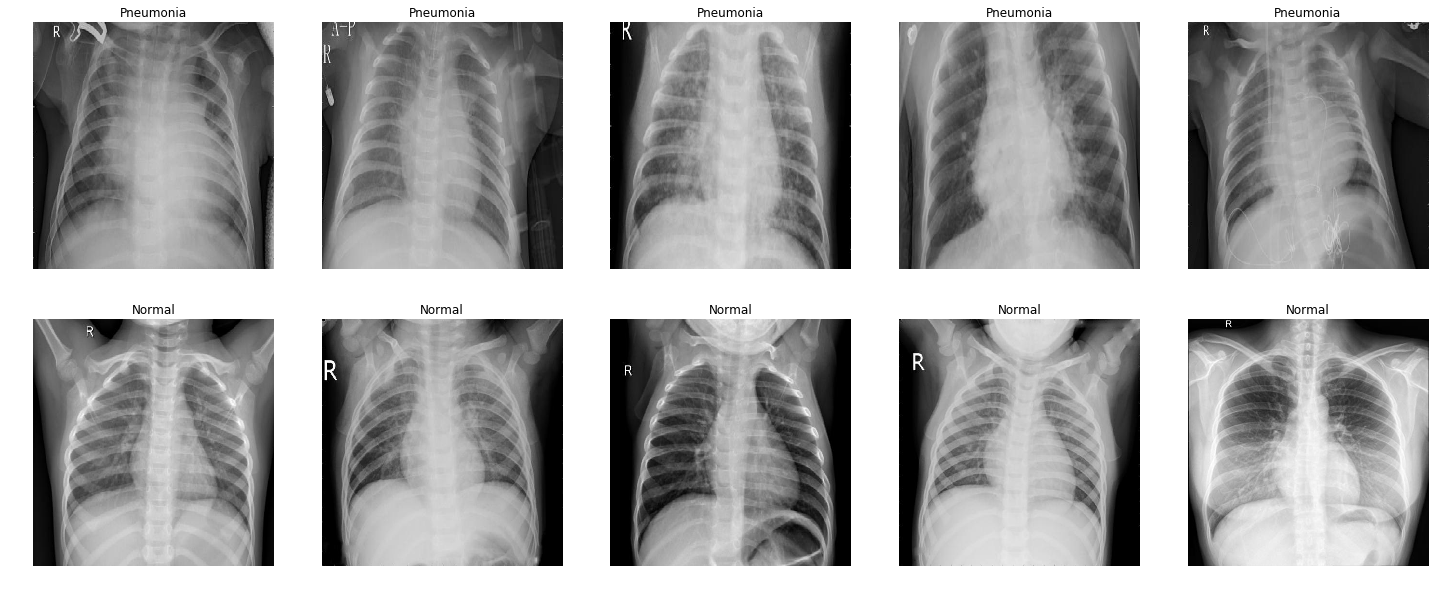

In [0]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(25,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#Preparing Data for Conv Model - without Augmentation


In [5]:
batch_size = 32

train_batches = ImageDataGenerator().flow_from_directory(train_dir,target_size = (224,224),classes = ['NORMAL','PNEUMONIA'],batch_size = batch_size) 
valid_batches = ImageDataGenerator().flow_from_directory(val_dir,target_size = (224,224),classes = ['NORMAL','PNEUMONIA'],batch_size = 2) 
test_batches = ImageDataGenerator().flow_from_directory(test_dir,target_size = (224,224),classes = ['NORMAL','PNEUMONIA'],batch_size = batch_size) 

Found 5208 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
#plot images with labels
def plots(ims, figsize=(20,10), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
      

In [0]:
ims,labels = next(train_batches)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


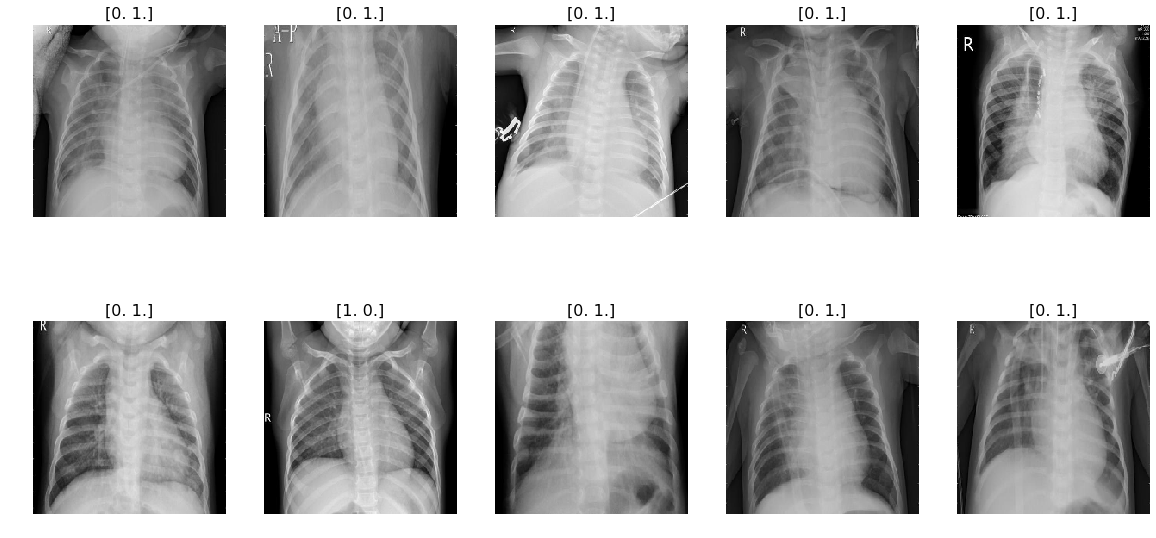

In [8]:
plots(ims[0:10],titles=labels)

# Define Conv Model

In [0]:
from keras import backend as K
K.set_image_dim_ordering('tf')

In [10]:
# Design the model
model = Sequential()

#first Conv Layer with input
model.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#second Conv Layer
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Third Conv Layer
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Forth Conv layer
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# the model so far outputs 3D feature maps (height, width, features)
#lets flatten the images

#First Dense layer
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

#Second Dense layer
model.add(Dense(128))
model.add(Activation('relu'))

#Final logistic layer 
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))


#Compile the model
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])


W0820 03:14:13.970582 140227104712576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 03:14:14.021928 140227104712576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 03:14:14.034774 140227104712576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 03:14:14.069931 140227104712576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0820 03:14:14.143052 140227104712576 deprecation_wrapp

# Train Model

In [11]:
model.fit_generator(train_batches,steps_per_epoch = 5208//batch_size,
                   epochs=5,
                  validation_data=valid_batches,
                  validation_steps=8,
                   verbose = 2)



Epoch 1/5


KeyboardInterrupt: ignored

In [0]:
model.save_weights('xray_images_second_try_withvalbatch_8.h5') 

# Predict

In [0]:
test_imgs,test_labels = next(test_batches)
plots(test_imgs[0:10],titles=labels)

In [0]:
test_labels = []
for i in range(1,21):
  test_imgs,y_test = next(test_batches)
  test_labels.append(y_test)
  
from itertools import chain
test_labels= list(chain(*test_labels))

test_labels = np.asarray(test_labels)[:,0]
len(test_labels)


In [0]:
predictions = model.model.predict_generator(test_batches,steps = 20,verbose = 1)
predictions = np.array(predictions[:,0])
predictions_1 = np.where(predictions<0.5, 0,1) 

In [0]:
def prediction_report(test_labels,predictions):
  cm = confusion_matrix(test_labels,predictions)  
  print("Accuracy {%}".format(accuracy_score(test_labels,predictions))
  print("precision {%}".format(precision_score(test_labels,predictions))
  print("Recall {%}".format(recall_score(test_labels,predictions))
  print("\n")
        
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['NORMAL','PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL','PNEUMONIA']);

prediction_report(test_labels,predictions_1)

# Using Resnet50

In [38]:
resnet = ResNet50(include_top=False,weights='imagenet')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [39]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
for layer in resnet.layers:
    layer.trainable = False

In [0]:
x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='sigmoid')(x)
resnet = Model(resnet.input, predictions)

In [42]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
resnet.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
resnet.fit_generator(train_batches,steps_per_epoch = 5208//batch_size,
                   epochs=5,
                  validation_data=valid_batches,
                  validation_steps=8,
                   verbose = 2)

Epoch 1/5


In [0]:
resnet.save('resnet.h5')